# Project 4


Classification/prediction of text reviews is a useful tool for many different fields and is a perfect application of Natural Language Processing (NLP) techniques within Machine Learning/Deep Learning.  

In this case, we will attend to video game reviews on the Steam platform (a digital distribution service and storefront developed by Valve).  Launched in 2003, users are able to purchase and download games from Steam, as well as use their cloud storage to backup saved games for use across multiple devices.  As of March 29, 2022, Steam reports over 27 million concurrent users at peak logged in to their service, with over 120 million users total.   



Currently, users are able to supply "would recommend"/"would not recommend" binary ratings, along with text reviews of games on Steam.  This provides us with a data set of labeled data from which to begin.

Stakeholders in this process include (but aren't limited to)
- Valve (or other digital distributors, e.g. Epic Games, Apple App Store, Google Play), 
- video game developers/publishers, 
- video game consumers (including reviewers, critics, players, streamers, etc.), 
- computer hardware manufacturers (knowledge about what games are popular could drive  video card architecture, e.g.)  
- cultural linguists (due to the nuanced and specialized vernacular exhibited by video gaming communities).

Business problems that such an investigation could illuminate include:
- validation of new ratings (i.e. checking consistency between user text and user binary rating).  This could be helpful for several reasons.  
    - Prompting users to double-check that they provided the intended binary rating, if their text review seems inconsistent.  
    - Notifying Valve of potential abuse/manipulation of the rating system, in the event that users are repeatedly providing inconsistent rating/review combinations.  
- automatically applying a binary rating to unlabeled reviews, which might be accessible, for example, from scrubbing the web for other game reviews.  

- generating a more nuanced rating number for each review than just 0 or 1; this could be more representative when aggregating the reviews.  
    - For example, a game which received three reviews, two that were just slightly negative and one very positive would receive binary scores of 0, 0, and 1, while receiving nuanced scores of .4, .4, and .9.  Another game could receive two very negative reviews and one slightly positive one and receive the same binary scores, (0, 0, 1) but receive different nuanced scores, .1, .1, and .6.  In aggregate, the binary system would rank these games the same, but would give a higher average nuanced rating to the former game.



In [1]:
# Useful global flags
SINGLE_SOURCE = True
 # this is used to either use only raw data, or to include options for cleaned/stemmed/lemmatized data - 
 # warning - if this is turned False, it creates substantially longer run time

In [2]:
import xgboost as xgb

In [3]:
from xgboost import XGBClassifier

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
#Ensure to download spacy and the corresponding package
# pip install -U spacy
# python -m spacy download en_core_web_sm

import spacy
spacy_nlp = spacy.load('en_core_web_sm')

In [6]:
import matplotlib.pyplot as plt 
import re 
import seaborn as sns 

import pandas as pd
import numpy as np
from collections import Counter

#must ensure conda install py-xgboost
#import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, RepeatVector
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import nltk 
from nltk.corpus import stopwords 
import string
import collections

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from wordcloud import WordCloud
import random

#from sklearn.pipeline import Pipeline
import pickle


Loading Data

In [7]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')


In [8]:
train_df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


In [10]:
train_df.describe()

,review_id,year,user_suggestion
count,17494.000000,17316.000000,17494.000000
mean,12423.216989,2016.388427,0.569795
std,7653.367660,1.390356,0.495119
min,1.000000,2011.000000,0.000000
25%,5769.250000,2015.000000,0.000000
50%,11756.500000,2017.000000,1.000000
75%,18926.750000,2018.000000,1.000000
max,25539.000000,2018.000000,1.000000


In [11]:
test_df.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


In [12]:
train_df.sample(5)

,review_id,title,year,user_review,user_suggestion
2171,2635,Path of Exile,2014.0,I truly consider this the great sequel to Diab...,1
7365,9740,The Elder Scrolls®: Legends™,2018.0,The Elder Scrolls legends game has stopped wor...,1
13161,18968,Fallout Shelter,2017.0,Fallout Shelter is a free to play time managem...,1
13977,19921,Infestation: The New Z,2016.0,Infestation has been for a long time now and s...,0
6209,8584,Heroes & Generals,2017.0,I played this game when it was relativly new a...,0


In [13]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8045 entries, 0 to 8044
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    8045 non-null   int64  
 1   title        8045 non-null   object 
 2   year         7978 non-null   float64
 3   user_review  8045 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 251.5+ KB


None

In [14]:
display(train_df.isna().sum())
display(test_df.isna().sum())
#year has some invalid entries, but we won't be using those.

review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64

review_id       0
title           0
year           67
user_review     0
dtype: int64

Really what we are concerned with here is the user_review (predictor) and user_suggestion (target) columns, the rest we can drop.  First, let's just check out the distribution by year.

In [15]:
train_df['year'].value_counts()
#so the data is mostly within the last 4 years of data (though a refreshed data pull could be useful for future work)

2018.0    4822
2016.0    4226
2017.0    3890
2015.0    2460
2014.0    1499
2013.0     340
2012.0      65
2011.0      14
Name: year, dtype: int64

In [16]:
#check distribution of value counts
train_df['user_suggestion'].value_counts()
#so there is a little imbalance, we could ignore it or rebalance by resampling.
#generally, resampling is only necessary when the imbalance is on the order of 1:10 - ours is much less severe than that.


1    9968
0    7526
Name: user_suggestion, dtype: int64

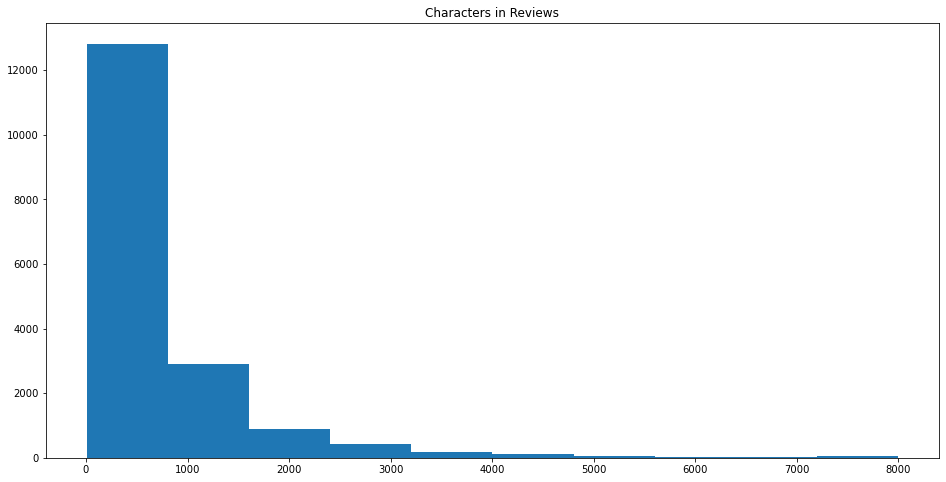

In [17]:
#Number of characters
class_len = train_df['user_review'].str.len()

plt.figure(figsize=(16,8))
plt.hist(class_len)
plt.title('Characters in Reviews')

plt.show()

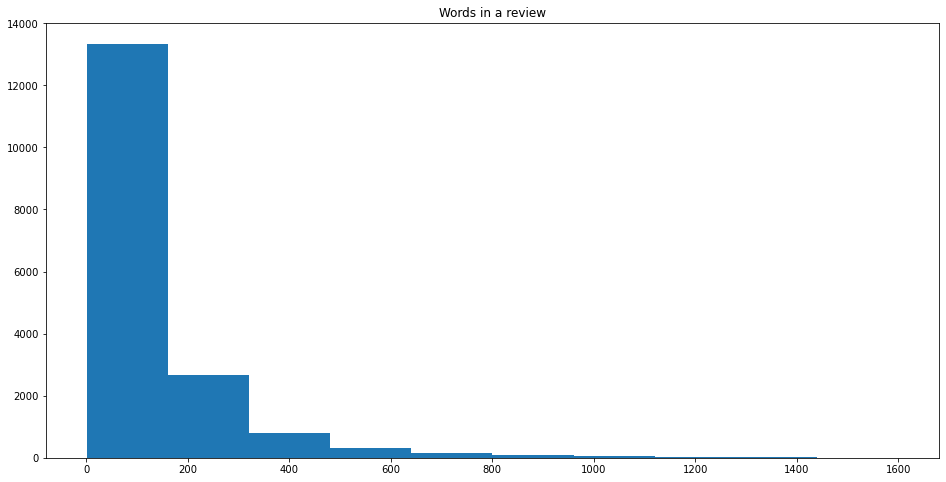

In [18]:
class_len = train_df['user_review'].str.split().map(lambda text: len(text))

plt.figure(figsize=(16,8))
plt.hist(class_len)
plt.title('Words in a review')

plt.show()

In [19]:
STOPWORDS = stopwords.words('english')
print(STOPWORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [20]:
def create_corpus(sug=None):
    #print('sugg',sug)
    if sug==None:#all reviews
        corpus = []
        for sentence in train_df['user_review'].str.split():
            for word in sentence:
                corpus.append(word.lower())

        return corpus
    elif sug == 0: #negative reviews
        corpus = []
        for sentence in train_df[train_df['user_suggestion'] == sug]['user_review'].str.split():
            for word in sentence:
                corpus.append(word.lower())

        return corpus
    elif sug == 1: #positive reviews
        corpus = []
        for sentence in train_df[train_df['user_suggestion'] == sug]['user_review'].str.split():
            for word in sentence:
                corpus.append(word.lower())

        return corpus

<BarContainer object of 20 artists>

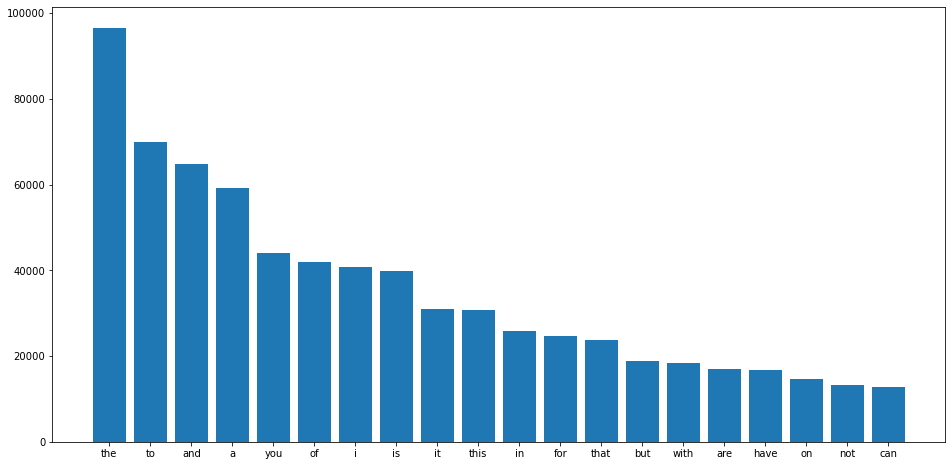

In [21]:
#Look at top 20 most common stopwords in our data
corpus = create_corpus()
dic = collections.defaultdict(int)

for word in corpus:
    if word in STOPWORDS:
        dic[word] += 1

x, y = zip(*sorted(dic.items(), key=lambda word: word[1], reverse=True)[:20])

plt.figure(figsize=(16, 8))
plt.bar(x, y)

In [22]:
# nothing alarming with the stop-words

<AxesSubplot:title={'center':'Bar plot for all reviews'}>

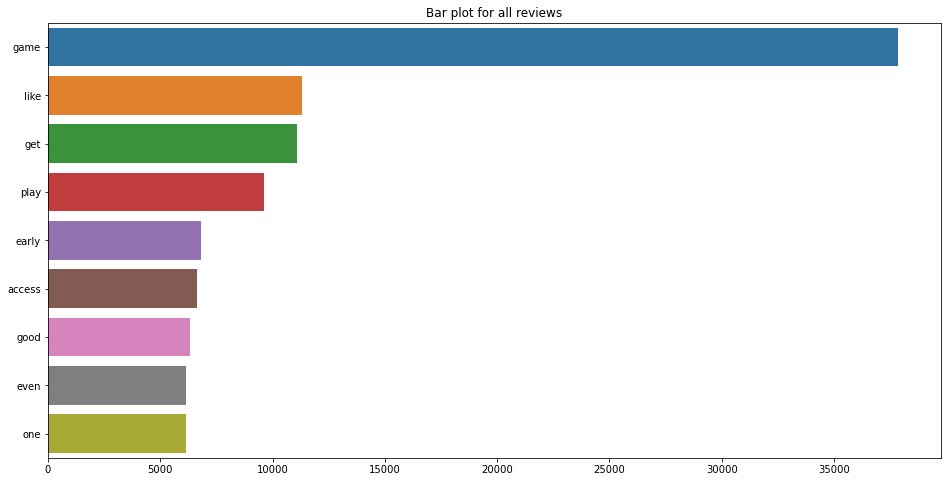

In [23]:
#Plot the most common words in review
corpus = create_corpus()
counter = collections.Counter(corpus)
most_common = counter.most_common()

x, y = [], []

for word, count in most_common[:50]:
    if word not in STOPWORDS:
        x.append(word)
        y.append(count)
#import seaborn as sns 

plt.figure(figsize=(16, 8))
plt.title('Bar plot for all reviews')
sns.barplot(x=y, y=x)

In [24]:
#Add a color theme for the following wordcloud:
def purple_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl({}, {}%, {}%)".format(random.randint(220,330), random.randint(60, 80), random.randint(60, 80))
            #"hsl(0, 0%%, %d%%)" % random.randint(60, 100)


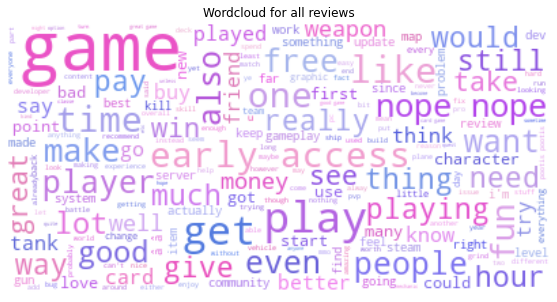

In [25]:
#Everybody loves a good word cloud
from wordcloud import WordCloud
corpus = create_corpus()
all_words = ' '.join(corpus) 

wordcloud = WordCloud(max_font_size=50, background_color='white', color_func=purple_color_func, stopwords=STOPWORDS).generate(all_words)

plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for all reviews')

plt.show()

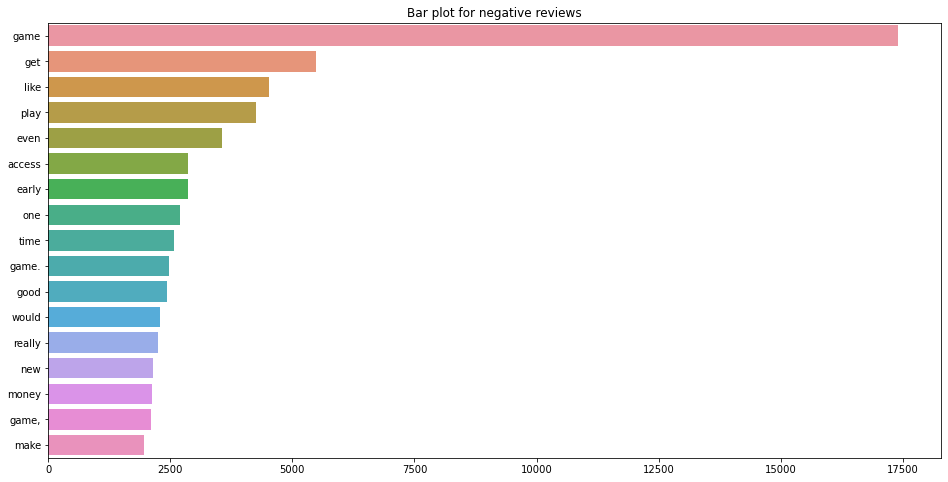

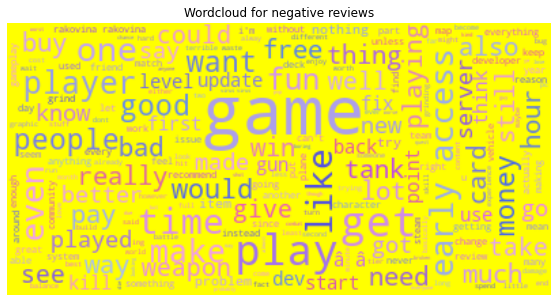

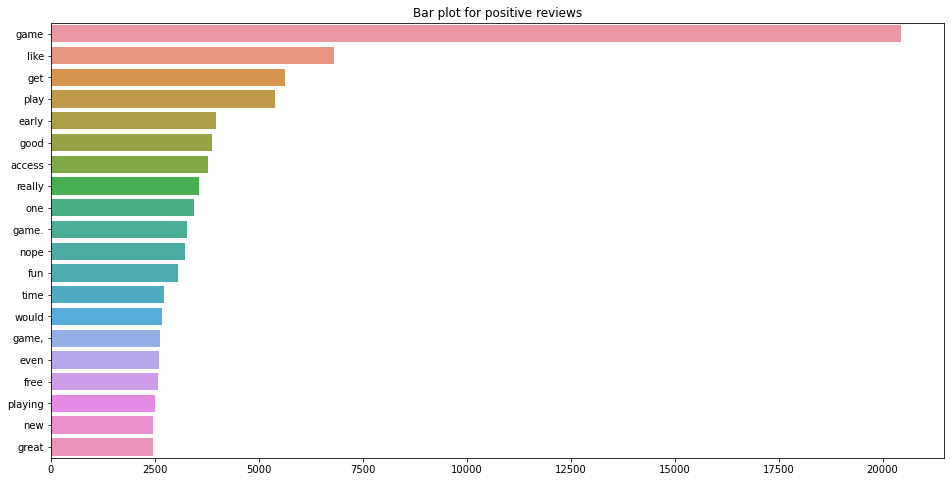

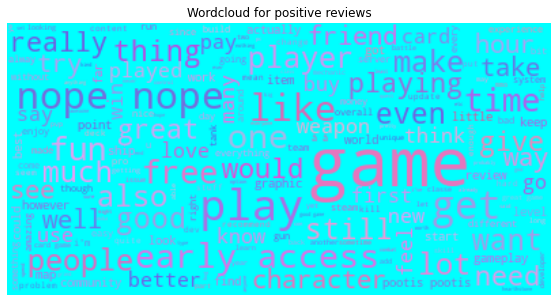

In [26]:
#Let's check out word frequency for negative-only and positive-only reviews as well
for i in range(0,2):
    
    #Plot the most common words in review
    corpus = create_corpus(i)
    counter = collections.Counter(corpus)
    most_common = counter.most_common()

    x, y = [], []

    #remove this
    #print(most_common[:75])
    for word, count in most_common[:75]:
        if word not in STOPWORDS:
            x.append(word)
            y.append(count)
    #import seaborn as sns 
    if i==0:
        neg_top_10=[x[:10], y[:10]]
    elif i==1:
        pos_top_10=[x[:10], y[:10]]

    plt.figure(figsize=(16, 8))
    sns.barplot(x=y, y=x)
    plt.title('Bar plot for {} reviews'.format('positive' if i==1 else 'negative'))

    #Everybody loves a good word cloud
    from wordcloud import WordCloud

    all_words = ' '.join(corpus) 
    
    bc='cyan' if i==1 else 'yellow'
    wordcloud = WordCloud(max_font_size=50, background_color=bc, color_func=purple_color_func, stopwords=STOPWORDS).generate(all_words)

    plt.figure(figsize=(15,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Wordcloud for {} reviews'.format('positive' if i==1 else 'negative'))

    plt.show()

Curiously, people use some words most frequently when discussing a game, whether positively or negatively.  If a word count approach is going to be helpful, it will likely tune in on less frequent (but important) words.

In [27]:
neg_top_10

[['game',
  'get',
  'like',
  'play',
  'even',
  'access',
  'early',
  'one',
  'time',
  'game.'],
 [17411, 5475, 4513, 4260, 3568, 2863, 2858, 2698, 2570, 2469]]

In [28]:
pos_top_10

[['game',
  'like',
  'get',
  'play',
  'early',
  'good',
  'access',
  'really',
  'one',
  'game.'],
 [20447, 6814, 5631, 5376, 3959, 3884, 3781, 3569, 3432, 3272]]


# Some typical preprocessing:
- Apply lowercase  
- Remove punctuation  
- Remove numbers  
- Remove stopwords  
- Remove white spaces  
- Apply lemmatization  

- and stemming???

If we turn off SINGLE_SOURCE (see top of notebook), we see that the three "cleaned" columns contain noticeable differences.  
Although lemmatization sounds like an ideal process to perform in general, familiar text, it may encounter some difficulties when we apply it to informal or vernacular text (which we see extensively in Steam reviews).  Let's process all three cleaned columns into a comparison model later and see how they do.  

NB: I have tested all 4 sets and the raw set works best for most models; I will proceed with that for now to save on processing time.  



In [29]:
INSPECT_ROW = 3
print('Original review\n', train_df['user_review'].iloc[INSPECT_ROW])
if not SINGLE_SOURCE:
    print('\nReview clean\n',train_df['review_cleaned'].iloc[INSPECT_ROW])
    print('\nReview lemmatized\n',train_df['review_lemma'].iloc[INSPECT_ROW])
    print('\nReview stemmed\n',train_df['review_stem'].iloc[INSPECT_ROW])

Original review
 Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because this is really enjoyable. But until then, I guess I'll settle for more Skyrim. Cheers!


In [30]:
#Apply lowercase
train_df['review_cleaned'] = train_df['user_review'].apply(lambda text: text.lower())

#Remove punctuation
# def remove_punctuation(sentence):
#     return ''.join([word for word in str(sentence) if word not in string.punctuation])

'''import string
a_string = '!hi. wh?at is the weat[h]er lik?e.'
new_string = a_string.translate(str.maketrans('', '', string.punctuation))
print(new_string)'''
import string
def remove_punctuation(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))
    
train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_punctuation(text))

#Remove numbers
def remove_numbers(sentence):
    return re.sub(r'\d+', '', sentence)

train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_numbers(text))

#Remove stopwords
def remove_stopwords(sentence):
    return ' '.join([word for word in str(sentence).split() if word not in STOPWORDS])
    
train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_stopwords(text))

#Remove white spaces
def remove_spaces(sentence):
    return re.sub(r'\s+', ' ', sentence).strip()

train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_spaces(text))

if not SINGLE_SOURCE:
    #Apply lemmatization
    spacy_lem = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    def lemmatizer_doc(sentence):
        doc = spacy_lem(sentence)
        new_sentence = [token.lemma_ for token in doc if token.is_alpha]  
        return ' '.join(new_sentence)

    train_df['review_lemma'] = train_df['review_cleaned'].apply(lambda text: lemmatizer_doc(text))

    # Apply stemming
    def stemmer(sentence):
        ps = PorterStemmer()
        return ps.stem(sentence)

    train_df['review_stem'] = train_df['review_cleaned'].apply(lambda text: stemmer(text))

In [31]:
#label encode to ensure y plays well with other parts
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train_df.user_suggestion.values)


In [32]:
if SINGLE_SOURCE:
    xtrain, xvalid, ytrain, yvalid = train_test_split(train_df.user_review.values, y, 
                                                      stratify=y, 
                                                      random_state=42, 
                                                      test_size=0.1, shuffle=True)
    xtrain_raw, xvalid_raw, ytrain_raw, yvalid_raw = xtrain, xvalid, ytrain, yvalid
else:
    xtrain_raw, xvalid_raw, ytrain_raw, yvalid_raw = train_test_split(train_df.user_review.values, y, 
                                                      stratify=y, 
                                                      random_state=42, 
                                                      test_size=0.1, shuffle=True)
    xtrain_cln, xvalid_cln, ytrain_cln, yvalid_cln = train_test_split(train_df.review_cleaned.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
    xtrain_lem, xvalid_lem, ytrain_lem, yvalid_lem = train_test_split(train_df.review_lemma.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
    xtrain_stm, xvalid_stm, ytrain_stm, yvalid_stm = train_test_split(train_df.review_stem.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
    suffixes = ['_raw', '_cln', '_lem', '_stm']

# Metrics
Different metrics inform our analysis in their own way.  There are some NLP projects that prioritize log-loss, AUC, f1, accuracy, and others. 

Part of our choice depends on the following question - should this analysis investigate or explore the level of nuance of a review?  Or should the end goal be simply to predict positivity/negativity well?  

- Log-loss is a highly useful metric for evaluating probability.  In this case, our models will be estimating a probability of being a positive review along the way (or, arguably, the level of positive sentiment in the review), so this will be a contender.  This measure will continue to give feedback throughout tuning.

- AUC (and ROC curves) measure the ability for a model to separate labels correctly into two distinct categories.  That is included in our goal, so this is also a contender metric that we will look at.  ROC curves can serve as a useful visualization for comparison of different models.  They are also useful when there is a mostly-even distribution in labels (which is what we have).  If they were not even, a precision-recall curve would be more useful.

- f1 is a blend of recall and precision, and is worth consideration.

- Accuracy will have less "gray area," and won't really be able to consider the nuance (e.g. a lukewarm review might give .6 positivity), but if our priority at the end of the line is to correctly predict positive/negative (and ignore the degree of each), then this could be considered.  This measure will likely give less feedback during tuning, as once a prediction meets the right label, it is considered good enough.



In [33]:
def score_report(ytrue, preds, bin_preds):
    #create score report for model predictions including log-loss, AUC/ROC, F1, accuracy
    log_l = log_loss(ytrue, predictions)
    print ("Model Log-loss: %0.3f " % log_l)
    try:
        f1=f1_score(ytrue, bin_preds)
        acc=accuracy_score(ytrue, bin_preds)
        
        print ("Model F1 score: %0.3f " % f1)
        print ("Model Accuracy score: %0.3f " % acc)
    except:
        f1=None
        acc=None
        print ("Model F1 score: not applicable")
        print ("Model Accuracy score: not applicable")
    #auc/roc
    majority = Counter(ytrue).most_common(1)[0][0]
    ns_probs = [majority for _ in range(len(ytrue))]
    ns_auc = roc_auc_score(ytrue, ns_probs)
    m_auc = roc_auc_score(ytrue, preds[:,1])#predictions
    print('Naive ROC AUC=%.3f' % (ns_auc))
    print('Model ROC AUC=%.3f' % (m_auc))
    ns_fpr, ns_tpr, _ = roc_curve(ytrue, ns_probs)
    m_fpr, m_tpr, _ = roc_curve(ytrue, preds[:,1])
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(m_fpr, m_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    return [log_l, f1, acc, m_auc]

In [34]:
# record model scores:
model_scores=[]

# Starting Models
- TF-IDF
- Logistic Regression

In [35]:
splits = ['_raw', '_cln', '_lem', '_stm']
def select_split(suffix):
    xtrain, xvalid, ytrain, yvalid = eval('xtrain'+suffix+', '+ 'xvalid'+suffix+', '+ 'ytrain'+suffix+', '+ 'yvalid'+suffix)
    return xtrain, xvalid, ytrain, yvalid


# On the raw user reviews

In [36]:
xtrain, xvalid, ytrain, yvalid = select_split(splits[0])
suffix=0

In [37]:
#First, try a tfidfVectorizer with default settings

tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

Scores for simple Logistic Regression on default TFIDF on _raw data.
Model Log-loss: 0.356 
Model F1 score: 0.878 
Model Accuracy score: 0.857 
Naive ROC AUC=0.500
Model ROC AUC=0.934


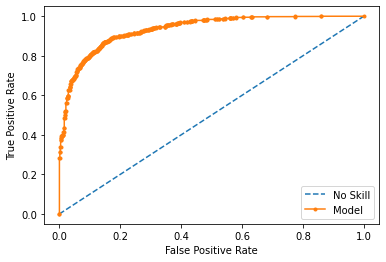

In [38]:
# Fit a simple Logistic Regression on TF-IDF
suffix=0
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)
# sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
#from sklearn.metrics import log_loss, f1_score, accuracy_score

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))
mname='Scores for simple Logistic Regression on default TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])
#Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
#binary outputs of .predict.  
#We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
#descriptive of what the regression is doing.


In [39]:
#model_scores

Scores for simple Logistic Regression on common parameters-TFIDF on _raw data.
Model Log-loss: 0.384 
Model F1 score: 0.879 
Model Accuracy score: 0.858 
Naive ROC AUC=0.500
Model ROC AUC=0.934


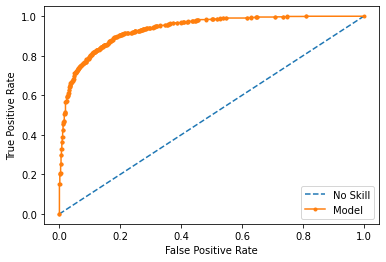

In [40]:
#Raw plus
suffix=0
xtrain, xvalid, ytrain, yvalid = select_split(splits[suffix])

# Following features are common starting points and work well in most cases.
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

#tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

# Fit a simple Logistic Regression on TF-IDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)
# sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
#from sklearn.metrics import log_loss, f1_score, accuracy_score

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))


mname='Scores for simple Logistic Regression on common parameters-TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])
#Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
#binary outputs of .predict.  
#We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
#descriptive of what the regression is doing.


# WARNING: If you rerun the cells below with SINGLE_SOURCE set to True, the score reports will be removed (the notebook is saved with them visible)

# On the cleaned reviews

In [41]:
if not SINGLE_SOURCE:
    suffix=1
    xtrain, xvalid, ytrain, yvalid = select_split(splits[suffix])
    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    # Fitting TF-IDF to both training and test sets (semi-supervised learning)
    tfv.fit(list(xtrain) + list(xvalid))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)

    #############

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))
    
   
    mname='Scores for simple Logistic Regression on common parameters-TFIDF on {} data.'.format(splits[suffix])
    print(mname)
    scores = [score_report(yvalid, predictions, bin_preds)]
    model_scores.append([mname, scores])
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


# On the lemmatized reviews

In [42]:
if not SINGLE_SOURCE:
    suffix=2
    xtrain, xvalid, ytrain, yvalid = select_split(splits[suffix])
    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    # Fitting TF-IDF to both training and test sets (semi-supervised learning)
    tfv.fit(list(xtrain) + list(xvalid))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)

    #############

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

    mname='Scores for simple Logistic Regression on common parameters-TFIDF on {} data.'.format(splits[suffix])
    print(mname)
    scores = [score_report(yvalid, predictions, bin_preds)]
    model_scores.append([mname, scores])
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


# On the stemmed reviews

In [43]:
if not SINGLE_SOURCE:
    suffix=3
    xtrain, xvalid, ytrain, yvalid = select_split(splits[suffix])
    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    # Fitting TF-IDF to both training and test sets (semi-supervised learning)
    tfv.fit(list(xtrain) + list(xvalid))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)

    #############

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

    mname='Scores for simple Logistic Regression on common parameters-TFIDF on {} data.'.format(splits[suffix])
    print(mname)
    scores = [score_report(yvalid, predictions, bin_preds)]
    model_scores.append([mname, scores])
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


Scores for simple Logistic Regression on TFIDF on _raw data.
Model Log-loss: 0.384 
Model F1 score: 0.879 
Model Accuracy score: 0.858 
Naive ROC AUC=0.500
Model ROC AUC=0.934


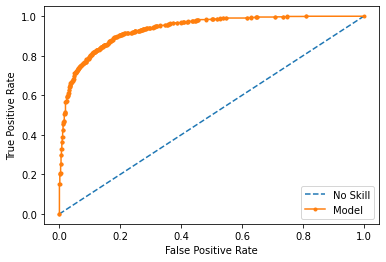

In [44]:
#Reinstantiate desired set
#Raw 
suffix=0
xtrain, xvalid, ytrain, yvalid = select_split(splits[0])

# Following features are common starting points and work well in most cases.
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

#tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

# Fit a simple Logistic Regression on TF-IDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)
# sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
#from sklearn.metrics import log_loss, f1_score, accuracy_score

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

mname='Scores for simple Logistic Regression on TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])
#Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
#binary outputs of .predict.  
#We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
#descriptive of what the regression is doing.


Somewhat unexpectedly, the built-in processing in TfidfVectorizer works best on logistic regression. Whether stemming/lemmatization underperform because they aren't capturing vernacular is unclear, but we will proceed with it (rerunning that cell below to re-initialize all its variables).  


# Word Counts - CountVectorizer

Instead of using TF-IDF, we can also use word counts as features. This can be done easily using CountVectorizer from scikit-learn.

In [41]:
xtrain, xvalid, ytrain, yvalid = select_split(splits[0])

ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [42]:
#checking out an arbitrary entry of that ctv
xtrain_ctv[1,2]

0

In [43]:
suffix=0

Scores for simple Logistic Regression on counts on _raw data.
Model Log-loss: 0.449 
Model F1 score: 0.872 
Model Accuracy score: 0.851 
Naive ROC AUC=0.500
Model ROC AUC=0.920


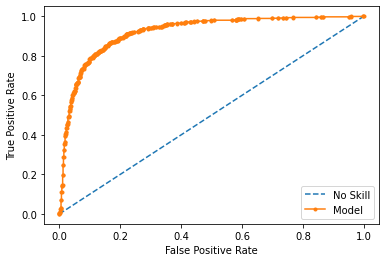

In [44]:
# Fit a simple Logistic Regression on those Counts
clf = LogisticRegression(C=1.0, max_iter=500,)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
bin_preds = clf.predict(xvalid_ctv)

mname='Scores for simple Logistic Regression on counts on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

In [49]:
if not SINGLE_SOURCE:
    #Looping through the 4 sets
    for suffix in range(len(splits)):
        xtrain, xvalid, ytrain, yvalid = select_split(splits[suffix])

        ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 3), stop_words = 'english')

        # Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
        ctv.fit(list(xtrain) + list(xvalid))
        xtrain_ctv =  ctv.transform(xtrain) 
        xvalid_ctv = ctv.transform(xvalid)

        # Fit a simple Logistic Regression on those Counts
        clf = LogisticRegression(C=1.0, max_iter=500,)
        clf.fit(xtrain_ctv, ytrain)
        predictions = clf.predict_proba(xvalid_ctv)
        bin_preds = clf.predict(xvalid_ctv)
        
        mname='Scores for Count Vectorized Logistic Regression on {} data.'.format(splits[suffix])
        print(mname)
        scores = [score_report(yvalid, predictions, bin_preds)]
        model_scores.append([mname, scores])
    

Scores for simple Naive Bayes on TF-IDF on _raw data.
Model Log-loss: 0.400 
Model F1 score: 0.868 
Model Accuracy score: 0.836 
Naive ROC AUC=0.500
Model ROC AUC=0.930


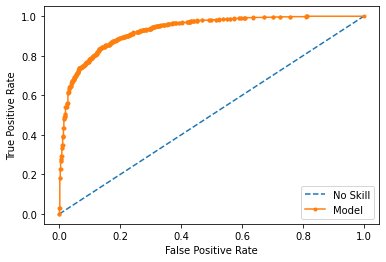

In [45]:
# Fit a simple Naive Bayes on TF-IDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)


mname='Scores for simple Naive Bayes on TF-IDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

What happens when we use this model on counts data instead?

Scores for simple Naive Bayes on Counts on _raw data.
Model Log-loss: 1.286 
Model F1 score: 0.876 
Model Accuracy score: 0.859 
Naive ROC AUC=0.500
Model ROC AUC=0.914


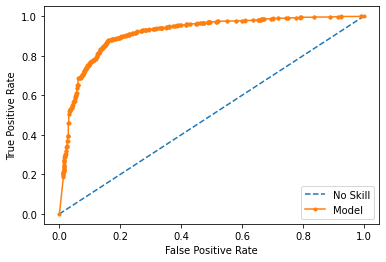

In [46]:
# Fit a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
bin_preds = clf.predict(xvalid_ctv)



mname='Scores for simple Naive Bayes on Counts on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])



NB on counts did not improve

One more classic algorithm is SVMs. 

In order to improve performance on time, we will reduce the number of features from the TF-IDF using Singular Value Decomposition before applying SVM.

Also, it is better to standardize the data before applying SVMs.

In [47]:
# Apply SVD, with 120 components. 120-200 components are widely considered sufficient for SVM.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

Now time to fit the SVM.  This can take a while!

Scores for simple SVM on scaled SVD on TF-IDF on _raw data.
Model Log-loss: 0.364 
Model F1 score: 0.865 
Model Accuracy score: 0.843 
Naive ROC AUC=0.500
Model ROC AUC=0.918


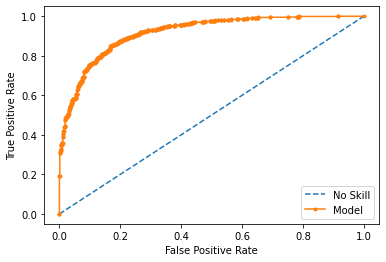

In [48]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we want probabilities in addition to the 0/1 scores
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)
bin_preds = clf.predict(xvalid_svd_scl)



mname='Scores for simple SVM on scaled SVD on TF-IDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

model1 = clf

This is even better loss and good f1/acc.

That performed pretty well on logloss.  Neat!  

Of course, we couldn't stop without trying XGBoost!

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:52:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple XGBoost on TFIDF on _raw data.
Model Log-loss: 0.393 
Model F1 score: 0.856 
Model Accuracy score: 0.831 
Naive ROC AUC=0.500
Model ROC AUC=0.911


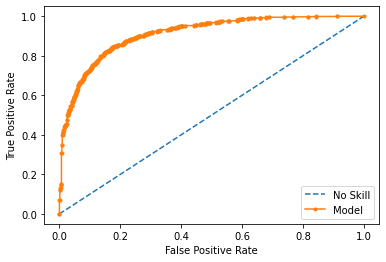

In [49]:
# Fit a basic xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())
bin_preds = clf.predict(xvalid_tfv.tocsc())


mname='Scores for simple XGBoost on TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Strangely, XGBoost didn't do as well on TF-IDF features as logistic regression.

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:52:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple XGBoost on TF-IDF SVD features on _raw data.
Model Log-loss: 0.421 
Model F1 score: 0.770 
Model Accuracy score: 0.721 
Naive ROC AUC=0.500
Model ROC AUC=0.894


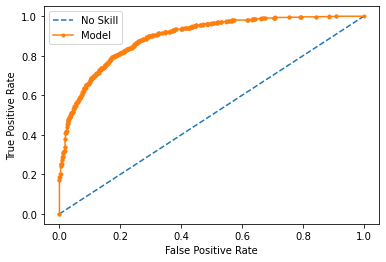

In [50]:
# Fitting a simple xgboost on tf-idf svd features with default parameters
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)
bin_preds = clf.predict(xvalid_svd_scl)

mname='Scores for simple XGBoost on TF-IDF SVD features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:52:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple XGBoost on TF-IDF SVD (with common hyperparams) features on _raw data.
Model Log-loss: 0.394 
Model F1 score: 0.845 
Model Accuracy score: 0.820 
Naive ROC AUC=0.500
Model ROC AUC=0.903


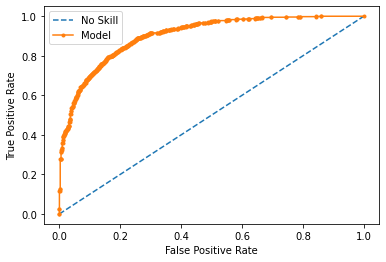

In [51]:
# Fit a basic xgboost on more common hyperparams for tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)
bin_preds = clf.predict(xvalid_svd)


mname='Scores for simple XGBoost on TF-IDF SVD (with common hyperparams) features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

On TF-IDF SVD unscaled features, XGBoost does not improve.  

What about on scaled features?

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:53:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on _raw data.
Model Log-loss: 0.394 
Model F1 score: 0.845 
Model Accuracy score: 0.820 
Naive ROC AUC=0.500
Model ROC AUC=0.903


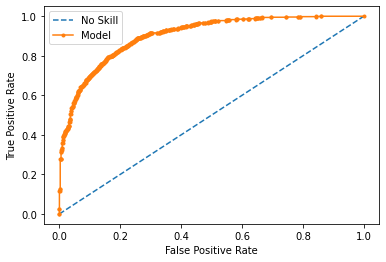

In [52]:
# Fit a basic xgboost on SCALED tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)
bin_preds = clf.predict(xvalid_svd_scl)

mname='Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

So, on Scaled TF-IDF SVD features, XGboost does very similarly.  

But wait!  We haven't done any tuning of hyperparameters yet.

# Improve all those models with some grid search optimization  
First, we can define a scoring metric for automation.  Log-loss will suffice for now, as it was represented the other metrics and seemed to be more sensitive.

In [43]:
basic_scorer = metrics.make_scorer(log_loss, greater_is_better=False, needs_proba=True)

Since we applied svd and scaling to to TF-IDF vectors, this seems like it has potential for a pipeline approach, in order to make the gridsearching across the svd and logistic regression all in one step.

In [57]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize a standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here.
lr_model = LogisticRegression()

# Create the Logistic Regression pipeline 
clf_lr = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

#Set up the parameter grid
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}
       
                         
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))              
    


Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed:  4.3min remaining:   51.1s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  5.1min finished
C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, 

[23:03:43] WARNING: ..\src\learner.cc:576: 
Parameters: { "lr__C", "lr__penalty", "svd__n_components" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:03:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: -0.407
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l1'
	svd__n_components: 120


Scores for gridsearched scaled svd on TFIDF on _raw data.
Model Log-loss: 0.344 
Model F1 score: 0.868 
Model Accuracy score: 0.846 
Naive ROC AUC=0.500
Model ROC AUC=0.927


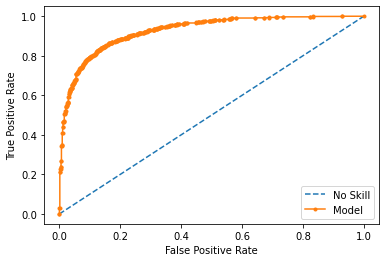

In [61]:
predictions = model.predict_proba(xvalid_tfv)
bin_preds = model.predict(xvalid_tfv)

mname='Scores for gridsearched scaled svd on TFIDF on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])


## Now Gridsearch on Naive Bayes

In [44]:
#Now try optimizing Naive Bayes
mname='Scores for gridsearched scaled TF-IDF SVD Naive Bayes on raw data.'
print(mname)

nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
#model2 = model


Scores for gridsearched scaled TF-IDF SVD Naive Bayes on raw data.
Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    2.0s remaining:    0.6s


Best score: -0.355
Best parameters set:
	nb__alpha: 0.1


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.1s finished
C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on _raw data.
Model Log-loss: 0.344 
Model F1 score: 0.868 
Model Accuracy score: 0.846 
Naive ROC AUC=0.500
Model ROC AUC=0.927


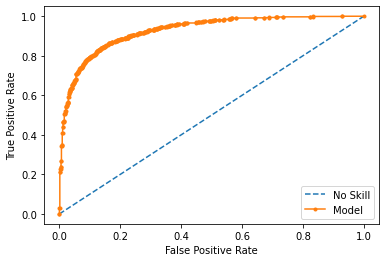

In [45]:
### testing it

clf = MultinomialNB(alpha=0.1)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)

mname='Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

model2 = model

# Pretrained Models

In [ ]:
# Some set-up # We can limit the GloVe data to our total vocabulary in question to avoid some encoding issues from glove
#total_vocabulary = set(word for headline in data for word in headline)

# GloVe vectors from here:
http://www-nlp.stanford.edu/data/glove.840B.300d.zip
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014.   
GloVe: Global Vectors for Word Representation. 

In [46]:
# load the GloVe vectors in a dictionary:
GLOVE_PATH = 'E:\Downloads\glove.840B.300d/glove.840B.300d.txt'
# class IncrementalDecoder(codecs.IncrementalDecoder):
#     def decode(self, input, final=False):
#         return codecs.charmap_decode(input,self.errors,decoding_table)[0]


'''with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector'''

embeddings_index = {}
with open(GLOVE_PATH, 'rb') as f:
    for line in tqdm(f):
        #print(line)
        parts = line.split()
        word = parts[0].decode('utf-8')
        try:
            coefs = np.asarray(parts[1:], dtype=np.float32)
        except BaseException as err:
            print(err)
            print(parts[0:10])
        embeddings_index[word] = coefs
    #f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:55, 9340.50it/s] 

Found 2196016 word vectors.


In [47]:
# Found 2196016 word vectors.
#parts

In [48]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [49]:
#original, non-looped
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 1750/1750 [00:03<00:00, 473.56it/s]


In [50]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [76]:
# if not SINGLE_SOURCE:
#     # create sentence vectors using the above function for training and validation set
#     glove_sets = {}
#     for i in range(len(suffixes)):
#         xtrain, xvalid, ytrain, yvalid = select_split(splits[i])
#         xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
#         xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]
#         glove_sets[splits[i]] = [xtrain_glove, xvalid_glove]

In [77]:
# if not SINGLE_SOURCE:
#     for i in range(len(suffixes)):
#         xtrain_glovet = glove_sets[splits[i]][0]
#         xvalid_glovet = glove_sets[splits[i]][1]
#         xtrain_glovet = np.array(xtrain_glovet)
#         xvalid_glovet = np.array(xvalid_glovet)
#         glove_sets[splits[i]][0] = xtrain_glovet
#         glove_sets[splits[i]][1] = xvalid_glovet

Check the performance of xgboost on glove features:`

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:10:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple XGBoost on glove features on _raw data.
Model Log-loss: 0.500 
Model F1 score: 0.818 
Model Accuracy score: 0.787 
Naive ROC AUC=0.500
Model ROC AUC=0.865


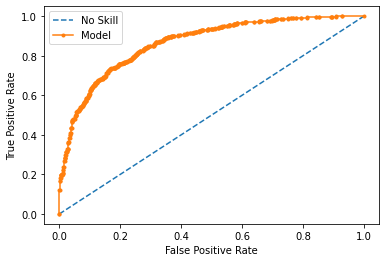

In [69]:
# Fit a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10)#, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)
bin_preds = clf.predict(xvalid_glove)


# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

mname='Scores for simple XGBoost on glove features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:11:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for slightly more tuned XGBoost on glove features on _raw data.
Model Log-loss: 0.440 
Model F1 score: 0.833 
Model Accuracy score: 0.805 
Naive ROC AUC=0.500
Model ROC AUC=0.885


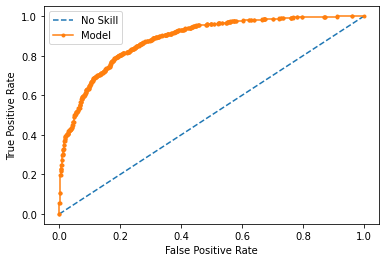

In [70]:
# Fit a slightly less simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1) #silent=False
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)
bin_preds = clf.predict(xvalid_glove)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

mname='Scores for slightly more tuned XGBoost on glove features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

In [71]:
# a simple tuning of parameters can improve xgboost score on GloVe features!
#but we can tune even more to improve further

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 17.3min finished
C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\Eric\anaconda3\envs\lear

[23:29:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: -0.431
Best parameters set:
	xgb__colsample_bytree: 0.5
	xgb__gamma: 0.2
	xgb__learning_rate: 0.1
	xgb__max_depth: 6
	xgb__min_child_weight: 3
Scores for gridsearched XGBoost on glove features on _raw data.
Model Log-loss: 0.440 
Model F1 score: 0.829 
Model Accuracy score: 0.800 
Naive ROC AUC=0.500
Model ROC AUC=0.874


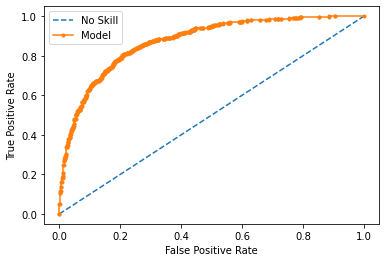

In [72]:
#Now try optimizing XGBoost a bit

xgb_model = xgb.XGBClassifier()

# Create the pipeline 
clf = pipeline.Pipeline([('xgb', xgb_model)])

# parameter grid

param_grid = {"xgb__learning_rate"    : [0.05, 0.10, 0.20] ,
 "xgb__max_depth"        : [ 6, 8],
 "xgb__min_child_weight" : [ 3],
 "xgb__gamma"            : [0.1, 0.2 , 0.4 ],
 "xgb__colsample_bytree" : [ 0.3, 0.5, 0.7] }                

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_glove, ytrain) 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

###probably need to set features
predictions = model.predict_proba(xvalid_glove)
bin_preds = model.predict(xvalid_glove)

mname='Scores for gridsearched XGBoost on glove features on {} data.'.format(splits[0])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])


In [82]:
###reprinted summary from above
# predictions = model.predict_proba(xvalid_glove)
# bin_preds = model.predict(xvalid_glove)

# mname='Scores for gridsearched XGBoost on glove features on {} data.'.format(splits[0])
# print(mname)
# scores = [score_report(yvalid, predictions, bin_preds)]
##### model_scores.append([mname, scores])

# Deep Learning   
Dense network, RNN, LSTM and GRU

In [51]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [52]:
# # looped if we want to inspect the different cleaning levels
# glovescls = {}
# for i in range(len(suffixes)):
#     xtrain_glovel, xvalid_glovel = glove_sets[splits[i]][0], glove_sets[splits[i]][1]
    
#     scl = preprocessing.StandardScaler()
#     xtrain_glove_scll = scl.fit_transform(xtrain_glove)
#     xvalid_glove_scll = scl.transform(xvalid_glove)
    
#     glovescls[splits[i]] = [xtrain_glove_scll, xvalid_glove_scll]


In [53]:
display(xtrain_glove_scl.shape)
xvalid_glove_scl.shape

(15744, 300)

(1750, 300)

In [75]:
ytrain.shape

(15744,)

In [76]:
ytrain

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [77]:
yvalid.shape

(1750,)

In [54]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [79]:
display(ytrain_enc.shape)
display(yvalid_enc.shape)
ytrain_enc

(15744, 2)

(1750, 2)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
if not SINGLE_SOURCE:
    #looping through the different cleaning levels, if necessary
    for i in range(len(suffixes)):
        # create a 3 layer sequential neural net
        model = Sequential()

        model.add(Dense(300, input_dim=300, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(300, activation='relu'))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())

        model.add(Dense(2))
        model.add(Activation('softmax'))

        # compile the model
        model.compile(loss='binary_crossentropy', optimizer='adam')

        xtrain_glove_scll, xvalid_glove_scll = glovescls[splits[i]][0], glovescls[splits[i]][1]
        print('for set {}'.format(splits[i]))
        model.fit(xtrain_glove_scll, y=ytrain_enc, batch_size=64, 
              epochs=20, verbose=1, 
              validation_data=(xvalid_glove_scll, yvalid_enc))
        results = model.evaluate(xvalid_glove_scll, yvalid_enc, batch_size=128)

In [55]:
# create a 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')



Epoch 1/8
246/246 [==============================] - 1s 5ms/step - loss: 0.5458 - val_loss: 0.4313
Epoch 2/8
246/246 [==============================] - 1s 4ms/step - loss: 0.4100 - val_loss: 0.4001
Epoch 3/8
246/246 [==============================] - 1s 4ms/step - loss: 0.3771 - val_loss: 0.3968
Epoch 4/8
246/246 [==============================] - 1s 4ms/step - loss: 0.3565 - val_loss: 0.4011
Epoch 5/8
246/246 [==============================] - 1s 4ms/step - loss: 0.3371 - val_loss: 0.3824
Epoch 6/8
246/246 [==============================] - 1s 4ms/step - loss: 0.3230 - val_loss: 0.3891
Epoch 7/8
246/246 [==============================] - 1s 4ms/step - loss: 0.3049 - val_loss: 0.4093
Epoch 8/8
246/246 [==============================] - 1s 4ms/step - loss: 0.2883 - val_loss: 0.4145
Instructions for updating:
Please use `model.predict()` instead.
Scores for 3 layer sequential neural net.
Model Log-loss: 0.415 
Model F1 score: not applicable
Model Accuracy score: not applicable
Naive ROC 

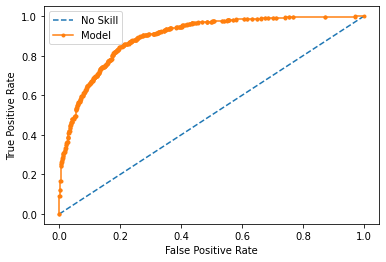

In [56]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=8, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

#results = model.evaluate(xvalid_glove_scl, yvalid_enc, batch_size=128)
predictions = model.predict_proba(xvalid_glove_scl)
bin_preds = model.predict(xvalid_glove_scl)

#results
mname='Scores for 3 layer sequential neural net.'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Note that from here forward, the Deep learning tools are just giving loss scores (by default, sparse categorical cross entropy which is the same as log-loss for this scenario).  We will proceed by comparing loss scores from here out.

So we can see that past epoch 4, we are overtraining.  Still, this is very quick and does rather well.  Let's tune the model architecture a bit and try again.

In [106]:
# create a 8 layer sequential neural net with .3-.5 dropout
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(800, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

Epoch 1/15
246/246 [==============================] - 3s 13ms/step - loss: 0.7287 - val_loss: 0.4846
Epoch 2/15
246/246 [==============================] - 3s 12ms/step - loss: 0.5060 - val_loss: 0.4296
Epoch 3/15
246/246 [==============================] - 3s 12ms/step - loss: 0.4533 - val_loss: 0.4058
Epoch 4/15
246/246 [==============================] - 3s 12ms/step - loss: 0.4221 - val_loss: 0.3977
Epoch 5/15
246/246 [==============================] - 3s 12ms/step - loss: 0.4026 - val_loss: 0.3959
Epoch 6/15
246/246 [==============================] - 3s 12ms/step - loss: 0.3808 - val_loss: 0.3990
Epoch 7/15
246/246 [==============================] - 3s 12ms/step - loss: 0.3666 - val_loss: 0.3896
Epoch 8/15
246/246 [==============================] - 3s 12ms/step - loss: 0.3542 - val_loss: 0.3895
Epoch 9/15
246/246 [==============================] - 3s 12ms/step - loss: 0.3456 - val_loss: 0.3822
Epoch 10/15
246/246 [==============================] - 3s 12ms/step - loss: 0.3328 - val_lo

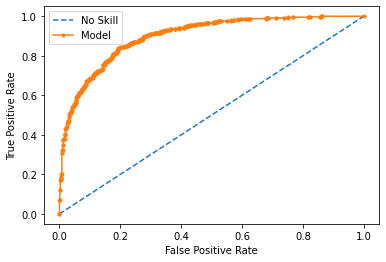

In [109]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=10, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

mname='Scores for 8 layer sequential neural net with .3-.5 dropout.'
predictions = model.predict_proba(xvalid_glove_scl)
bin_preds = model.predict(xvalid_glove_scl)

#results
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

In [82]:
# xtrain = xtrain_raw
# xvalid = xvalid_raw

# xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
# xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

# scl = preprocessing.StandardScaler()
# xtrain_glove_scl = scl.fit_transform(xtrain_glove)
# xvalid_glove_scl = scl.transform(xvalid_glove)

100%|██████████| 1750/1750 [00:03<00:00, 469.50it/s]


Epoch 1/17
246/246 [==============================] - 3s 13ms/step - loss: 0.8586 - val_loss: 0.6646
Epoch 2/17
246/246 [==============================] - 3s 12ms/step - loss: 0.6879 - val_loss: 0.6036
Epoch 3/17
246/246 [==============================] - 3s 12ms/step - loss: 0.5781 - val_loss: 0.4814
Epoch 4/17
246/246 [==============================] - 3s 12ms/step - loss: 0.5105 - val_loss: 0.4386
Epoch 5/17
246/246 [==============================] - 3s 12ms/step - loss: 0.4760 - val_loss: 0.4185
Epoch 6/17
246/246 [==============================] - 3s 12ms/step - loss: 0.4531 - val_loss: 0.4083
Epoch 7/17
246/246 [==============================] - 3s 12ms/step - loss: 0.4432 - val_loss: 0.4070
Epoch 8/17
246/246 [==============================] - 3s 12ms/step - loss: 0.4265 - val_loss: 0.3965
Epoch 9/17
246/246 [==============================] - 3s 12ms/step - loss: 0.4189 - val_loss: 0.3953
Epoch 10/17
246/246 [==============================] - 3s 12ms/step - loss: 0.4144 - val_lo

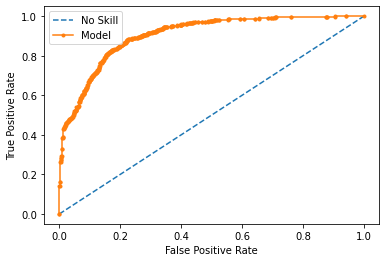

In [115]:
# testing 8 layer dense neural net with .5 dropout instead of varied
#original, non-looped
# create a 8 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(800, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=17, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

mname='Scores for 8 layer dense neural net with .5 dropout'
predictions = model.predict_proba(xvalid_glove_scl)
bin_preds = model.predict(xvalid_glove_scl)

print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])



So, we can see after just a little tuning on dense deep neural nets, with some dropout, we can get better results than xgboost.  
Let's proceed into Recurrent Neural Nets (and then into LSTMs and GRUs)

# RNNs

In order to work with these, we should tokenize the text data.

In [83]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [84]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 59101/59101 [00:00<00:00, 277664.90it/s]


Epoch 1/100
31/31 [==============================] - 7s 222ms/step - loss: 0.6978 - val_loss: 0.5856
Epoch 2/100
31/31 [==============================] - 7s 210ms/step - loss: 0.6014 - val_loss: 0.5725
Epoch 3/100
31/31 [==============================] - 7s 211ms/step - loss: 0.5822 - val_loss: 0.5563
Epoch 4/100
31/31 [==============================] - 7s 210ms/step - loss: 0.5586 - val_loss: 0.5491
Epoch 5/100
31/31 [==============================] - 6s 206ms/step - loss: 0.5536 - val_loss: 0.5353
Epoch 6/100
31/31 [==============================] - 6s 206ms/step - loss: 0.5495 - val_loss: 0.5586
Epoch 7/100
31/31 [==============================] - 6s 209ms/step - loss: 0.5440 - val_loss: 0.5433
Epoch 8/100
31/31 [==============================] - 6s 205ms/step - loss: 0.5390 - val_loss: 0.5317
Epoch 9/100
31/31 [==============================] - 6s 206ms/step - loss: 0.5280 - val_loss: 0.5291
Epoch 10/100
31/31 [==============================] - 6s 205ms/step - loss: 0.5278 - val_lo

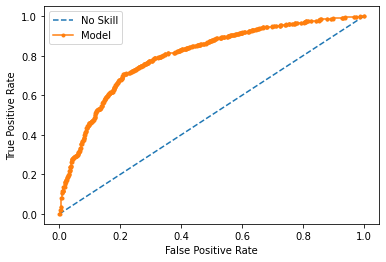

In [119]:
# A basic RNN with glove embeddings and two dense layers - batch size 512
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(SimpleRNN(100))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=30, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])
#model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='basic RNN with glove embeddings and two dense layers - batch size 512'

print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])


Epoch 1/100
31/31 [==============================] - 7s 211ms/step - loss: 0.7125 - val_loss: 0.6578
Epoch 2/100
31/31 [==============================] - 7s 210ms/step - loss: 0.6258 - val_loss: 0.5782
Epoch 3/100
31/31 [==============================] - 6s 201ms/step - loss: 0.5838 - val_loss: 0.6495
Epoch 4/100
31/31 [==============================] - 6s 202ms/step - loss: 0.5881 - val_loss: 0.5603
Epoch 5/100
31/31 [==============================] - 6s 201ms/step - loss: 0.5599 - val_loss: 0.5640
Epoch 6/100
31/31 [==============================] - 6s 200ms/step - loss: 0.5561 - val_loss: 0.5545
Epoch 7/100
31/31 [==============================] - 6s 201ms/step - loss: 0.5549 - val_loss: 0.5441
Epoch 8/100
31/31 [==============================] - 6s 200ms/step - loss: 0.5485 - val_loss: 0.5445
Epoch 9/100
31/31 [==============================] - 6s 202ms/step - loss: 0.5359 - val_loss: 0.5476
Epoch 10/100
31/31 [==============================] - 6s 207ms/step - loss: 0.5343 - val_lo

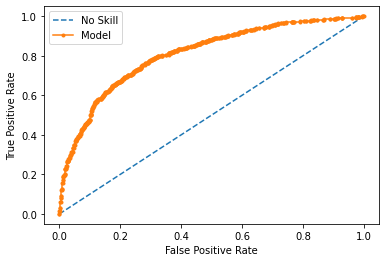

In [120]:
# A basic RNN with glove embeddings and two dense layers - change batch size to 64 not 512
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(SimpleRNN(100))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])
#model.fit(xtrain_pad, y=ytrain_enc, batch_size=64, epochs=20, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='basic RNN with glove embeddings and two dense layers - change batch size to 64 not 512'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])


Interesting, reducing the batch size made loss worse.  There were seemingly not enough samples in each batch to settle in on one gradient direction.

# LSTMs


Epoch 1/100
31/31 [==============================] - 81s 3s/step - loss: 0.6622 - val_loss: 0.5828
Epoch 2/100
31/31 [==============================] - 83s 3s/step - loss: 0.5546 - val_loss: 0.4864
Epoch 3/100
31/31 [==============================] - 85s 3s/step - loss: 0.5266 - val_loss: 0.4738
Epoch 4/100
31/31 [==============================] - 89s 3s/step - loss: 0.5232 - val_loss: 0.5216
Epoch 5/100
31/31 [==============================] - 91s 3s/step - loss: 0.5174 - val_loss: 0.5027
Epoch 6/100
31/31 [==============================] - 90s 3s/step - loss: 0.4964 - val_loss: 0.4532
Epoch 7/100
31/31 [==============================] - 92s 3s/step - loss: 0.4805 - val_loss: 0.4504
Epoch 8/100
31/31 [==============================] - 96s 3s/step - loss: 0.4722 - val_loss: 0.4356
Epoch 9/100
31/31 [==============================] - 94s 3s/step - loss: 0.4572 - val_loss: 0.4330
Epoch 10/100
31/31 [==============================] - 92s 3s/step - loss: 0.4398 - val_loss: 0.4574
Epoch 11/

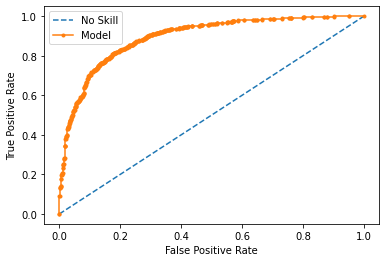

In [121]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='A simple LSTM with glove embeddings and two dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Note that the dropout above was necessary to avoid overfitting too much.  

Next, let's investigate Bi-directional LSTM.

Epoch 1/50
31/31 [==============================] - 185s 6s/step - loss: 0.6778 - val_loss: 0.6217
Epoch 2/50
31/31 [==============================] - 189s 6s/step - loss: 0.5803 - val_loss: 0.5271
Epoch 3/50
31/31 [==============================] - 198s 6s/step - loss: 0.5357 - val_loss: 0.4848
Epoch 4/50
31/31 [==============================] - 216s 7s/step - loss: 0.5097 - val_loss: 0.4694
Epoch 5/50
31/31 [==============================] - 229s 7s/step - loss: 0.4877 - val_loss: 0.4616
Epoch 6/50
31/31 [==============================] - 250s 8s/step - loss: 0.4805 - val_loss: 0.4538
Epoch 7/50
31/31 [==============================] - 235s 8s/step - loss: 0.4721 - val_loss: 0.4409
Epoch 8/50
31/31 [==============================] - 232s 7s/step - loss: 0.4544 - val_loss: 0.4312
Epoch 9/50
31/31 [==============================] - 231s 7s/step - loss: 0.4357 - val_loss: 0.4261
Epoch 10/50
31/31 [==============================] - 235s 8s/step - loss: 0.4256 - val_loss: 0.4187
Epoch 11/

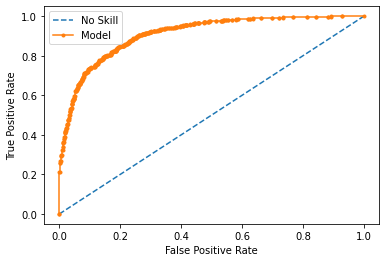

In [123]:
# A bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='A bidirectional LSTM with glove embeddings and two dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/50
31/31 [==============================] - 237s 8s/step - loss: 0.7326 - val_loss: 0.6878
Epoch 2/50
31/31 [==============================] - 237s 8s/step - loss: 0.6918 - val_loss: 0.6864
Epoch 3/50
31/31 [==============================] - 237s 8s/step - loss: 0.6786 - val_loss: 0.6251
Epoch 4/50
31/31 [==============================] - 237s 8s/step - loss: 0.6352 - val_loss: 0.5414
Epoch 5/50
31/31 [==============================] - 237s 8s/step - loss: 0.5783 - val_loss: 0.4908
Epoch 6/50
31/31 [==============================] - 235s 8s/step - loss: 0.5391 - val_loss: 0.5075
Epoch 7/50
31/31 [==============================] - 237s 8s/step - loss: 0.5256 - val_loss: 0.4706
Epoch 8/50
31/31 [==============================] - 237s 8s/step - loss: 0.5119 - val_loss: 0.4970
Epoch 9/50
31/31 [==============================] - 237s 8s/step - loss: 0.4948 - val_loss: 0.4590
Epoch 10/50
31/31 [==============================] - 237s 8s/step - loss: 0.4780 - val_loss: 0.4621
Epoch 11/

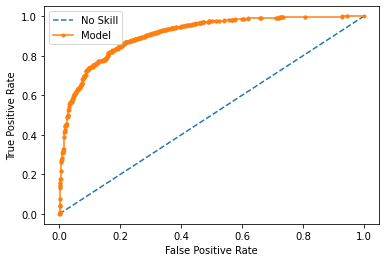

In [124]:
# A bidirectional LSTM with glove embeddings and three dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='A bidirectional LSTM with glove embeddings and three dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/50
31/31 [==============================] - 250s 8s/step - loss: 0.7482 - val_loss: 0.6904
Epoch 2/50
31/31 [==============================] - 250s 8s/step - loss: 0.7006 - val_loss: 0.6883
Epoch 3/50
31/31 [==============================] - 251s 8s/step - loss: 0.6892 - val_loss: 0.6871
Epoch 4/50
31/31 [==============================] - 252s 8s/step - loss: 0.6908 - val_loss: 0.6863
Epoch 5/50
31/31 [==============================] - 254s 8s/step - loss: 0.6871 - val_loss: 0.6859
Epoch 6/50
31/31 [==============================] - 254s 8s/step - loss: 0.6849 - val_loss: 0.6857
Epoch 7/50
31/31 [==============================] - 253s 8s/step - loss: 0.6818 - val_loss: 0.6840
Epoch 8/50
31/31 [==============================] - 253s 8s/step - loss: 0.6754 - val_loss: 0.6876
Epoch 9/50
31/31 [==============================] - 254s 8s/step - loss: 0.6718 - val_loss: 0.6363
Epoch 10/50
31/31 [==============================] - 254s 8s/step - loss: 0.6721 - val_loss: 0.6925
Epoch 11/

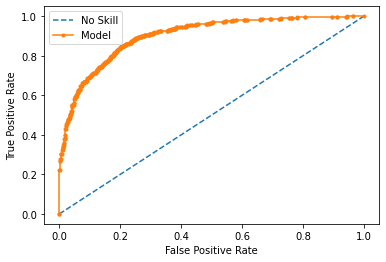

In [125]:
# A two-layer bidirectional LSTM with glove embeddings and three dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model.add(RepeatVector(2)) # Repeat Vector
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='A two-layer bidirectional LSTM with glove embeddings and three dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

LSTM does pretty well, depending on the architecture.  
Next, we try a popular approach, GRU with two layers, on glove embeddings

Epoch 1/100
31/31 [==============================] - 200s 6s/step - loss: 0.6731 - val_loss: 0.5924
Epoch 2/100
31/31 [==============================] - 198s 6s/step - loss: 0.6005 - val_loss: 0.5083
Epoch 3/100
31/31 [==============================] - 198s 6s/step - loss: 0.5515 - val_loss: 0.4728
Epoch 4/100
31/31 [==============================] - 198s 6s/step - loss: 0.5211 - val_loss: 0.4627
Epoch 5/100
31/31 [==============================] - 198s 6s/step - loss: 0.5009 - val_loss: 0.4540
Epoch 6/100
31/31 [==============================] - 200s 6s/step - loss: 0.4801 - val_loss: 0.4495
Epoch 7/100
31/31 [==============================] - 198s 6s/step - loss: 0.4694 - val_loss: 0.4298
Epoch 8/100
31/31 [==============================] - 199s 6s/step - loss: 0.4583 - val_loss: 0.4496
Epoch 9/100
31/31 [==============================] - 199s 6s/step - loss: 0.4384 - val_loss: 0.4209
Epoch 10/100
31/31 [==============================] - 199s 6s/step - loss: 0.4307 - val_loss: 0.4114

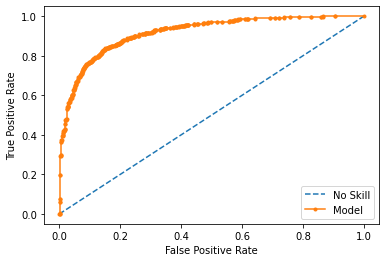

In [126]:
# Two layer GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='A Two layer GRU with glove embeddings and two dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/100
31/31 [==============================] - 196s 6s/step - loss: 0.7481 - val_loss: 0.6882
Epoch 2/100
31/31 [==============================] - 195s 6s/step - loss: 0.6908 - val_loss: 0.6857
Epoch 3/100
31/31 [==============================] - 195s 6s/step - loss: 0.6864 - val_loss: 0.6840
Epoch 4/100
31/31 [==============================] - 195s 6s/step - loss: 0.6848 - val_loss: 0.6836
Epoch 5/100
31/31 [==============================] - 195s 6s/step - loss: 0.6837 - val_loss: 0.6826
Epoch 6/100
31/31 [==============================] - 195s 6s/step - loss: 0.6842 - val_loss: 0.6833
Epoch 7/100
31/31 [==============================] - 195s 6s/step - loss: 0.6831 - val_loss: 0.6826
Epoch 8/100
31/31 [==============================] - 196s 6s/step - loss: 0.6815 - val_loss: 0.6778
Epoch 9/100
31/31 [==============================] - 195s 6s/step - loss: 0.6732 - val_loss: 0.6648
Epoch 10/100
31/31 [==============================] - 194s 6s/step - loss: 0.6661 - val_loss: 0.6691

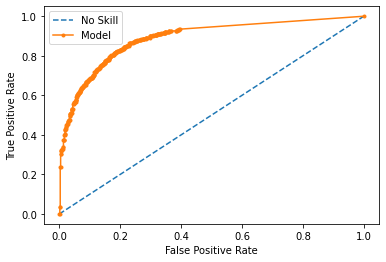

In [127]:
# Two layer GRU with glove embeddings and three dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='A Two layer GRU with glove embeddings and three dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/100
31/31 [==============================] - 519s 17s/step - loss: 0.7045 - val_loss: 0.6823
Epoch 2/100
31/31 [==============================] - 470s 15s/step - loss: 0.6875 - val_loss: 0.6842
Epoch 3/100
31/31 [==============================] - 484s 16s/step - loss: 0.6831 - val_loss: 0.6800
Epoch 4/100
31/31 [==============================] - 489s 16s/step - loss: 0.6749 - val_loss: 0.6785
Epoch 5/100
31/31 [==============================] - 497s 16s/step - loss: 0.6871 - val_loss: 0.6737
Epoch 6/100
31/31 [==============================] - 500s 16s/step - loss: 0.6741 - val_loss: 0.6641
Epoch 7/100
31/31 [==============================] - 504s 16s/step - loss: 0.6709 - val_loss: 0.6482
Epoch 8/100
31/31 [==============================] - 505s 16s/step - loss: 0.6399 - val_loss: 0.6023
Epoch 9/100
31/31 [==============================] - 499s 16s/step - loss: 0.6155 - val_loss: 0.5832
Epoch 10/100
31/31 [==============================] - 499s 16s/step - loss: 0.5830 - val_lo

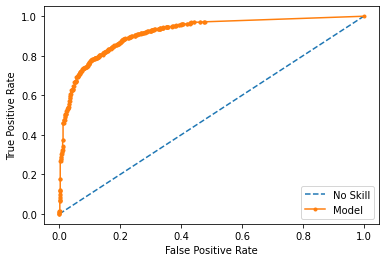

In [128]:
# 2-layer Bidirectional GRU with glove embeddings and two small dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
#model.add(RepeatVector(2)) # Repeat Vector
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='A 2-layer Bidirectional GRU with glove embeddings and two small dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

Epoch 1/100
31/31 [==============================] - 558s 18s/step - loss: 0.6957 - val_loss: 0.6096
Epoch 2/100
31/31 [==============================] - 551s 18s/step - loss: 0.5971 - val_loss: 0.5167
Epoch 3/100
31/31 [==============================] - 556s 18s/step - loss: 0.5277 - val_loss: 0.4946
Epoch 4/100
31/31 [==============================] - 575s 19s/step - loss: 0.5186 - val_loss: 0.5045
Epoch 5/100
31/31 [==============================] - 571s 18s/step - loss: 0.4933 - val_loss: 0.4583
Epoch 6/100
31/31 [==============================] - 575s 19s/step - loss: 0.4704 - val_loss: 0.4466
Epoch 7/100
31/31 [==============================] - 571s 18s/step - loss: 0.4563 - val_loss: 0.4467
Epoch 8/100
31/31 [==============================] - 570s 18s/step - loss: 0.4397 - val_loss: 0.4284
Epoch 9/100
31/31 [==============================] - 579s 19s/step - loss: 0.4282 - val_loss: 0.4373
Epoch 10/100
31/31 [==============================] - 578s 19s/step - loss: 0.4180 - val_lo

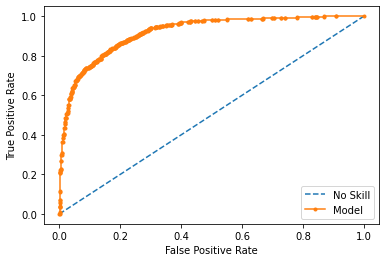

In [129]:
# Warning; runtime gets pretty long on this !!!
# 2-layer Bidirectional GRU with glove embeddings and two 1024 dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
#model.add(RepeatVector(2)) # Repeat Vector
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='A 2-layer Bidirectional GRU with glove embeddings and two 1024 dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

model3 = model

Epoch 1/100
31/31 [==============================] - 187s 6s/step - loss: 0.6942 - val_loss: 0.6840
Epoch 2/100
31/31 [==============================] - 184s 6s/step - loss: 0.6809 - val_loss: 0.6610
Epoch 3/100
31/31 [==============================] - 184s 6s/step - loss: 0.6509 - val_loss: 0.6187
Epoch 4/100
31/31 [==============================] - 184s 6s/step - loss: 0.6170 - val_loss: 0.5261
Epoch 5/100
31/31 [==============================] - 184s 6s/step - loss: 0.5902 - val_loss: 0.5238
Epoch 6/100
31/31 [==============================] - 184s 6s/step - loss: 0.5425 - val_loss: 0.4781
Epoch 7/100
31/31 [==============================] - 185s 6s/step - loss: 0.5083 - val_loss: 0.4456
Epoch 8/100
31/31 [==============================] - 185s 6s/step - loss: 0.4947 - val_loss: 0.4559
Epoch 9/100
31/31 [==============================] - 192s 6s/step - loss: 0.4793 - val_loss: 0.4443
Epoch 10/100
31/31 [==============================] - 188s 6s/step - loss: 0.4623 - val_loss: 0.4171

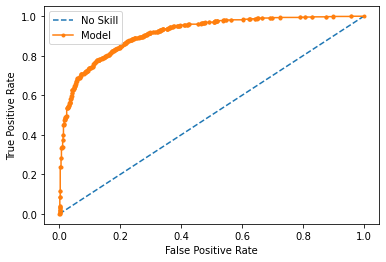

In [130]:
# single Bidirectional GRU with glove embeddings and four dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

predictions = model.predict_proba(xvalid_pad)
bin_preds = model.predict(xvalid_pad)

mname='A single Bidirectional GRU with glove embeddings and four dense layers'
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

In [ ]:
''' can improve these results even more.  consider stemming/lemmatization? '''

'''NEXT: Put in Apache so we can parallel process
Add other metrics

Add most commonly occuring words in positive/negative reviews
'''

# Pipeline and Pickle

In [ ]:
#Project checklists

#set up apache spark system to do parallel processing?
#maybe Try to set up amazon resources - possibly overkill/not good for github
## see recommendation systems section - this isn't actually directly applicable - more for recs for a user based on other user's recs
# topic 39 - nlp obvs
#tf-idfs?
#nnetworks with
# word2vec (including gensim) see https://learning.flatironschool.com/courses/1890/pages/using-word2vec?module_item_id=261958
#GloVe for classification - (This is a very good pretrained model)
# word embeddings, 
#sequence models e.g. 
#RNN and 
#lstms, 
#grus, 
#gridsearch for best params,
#ensemble methods - e.g. xgboost on these models
#anything else that is in 
# https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle/comments
'''tfidf
count features
logistic regression
naive bayes
svm
xgboost
grid search
word vectors
LSTM
GRU
Ensembling'''



In [122]:
model_scores

[['Scores for simple Logistic Regression on default TFIDF on _raw data.',
  [[0.35616010372985507,
    0.8775710088148874,
    0.8571428571428571,
    0.9338993074842056]]],
 ['Scores for simple Logistic Regression on common parameters-TFIDF on _raw data.',
  [[0.38449463375369297,
    0.8794188861985471,
    0.8577142857142858,
    0.9339785625135699]]],
 ['Scores for simple Logistic Regression on TFIDF on _raw data.',
  [[0.38449463375369297,
    0.8794188861985471,
    0.8577142857142858,
    0.9339785625135699]]],
 ['Scores for simple Logistic Regression on counts on _raw data.',
  [[0.449498641398137,
    0.8716182980816527,
    0.8508571428571429,
    0.919895143598125]]],
 ['Scores for simple Naive Bayes on TF-IDF on _raw data.',
  [[0.3998009198604091, 0.8679245283018867, 0.836, 0.9298999255402329]]],
 ['Scores for simple Naive Bayes on Counts on _raw data.',
  [[1.2858412722608112,
    0.876008064516129,
    0.8594285714285714,
    0.9135727234825325]]],
 ['Scores for simple S

In [85]:
#model1
#setup from scratch
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
xtrain, xvalid, ytrain, yvalid = train_test_split(train_df.user_review.values, y, 
                                                      stratify=y, 
                                                      random_state=42, 
                                                      test_size=0.1, shuffle=True)

#!!!
#code paste from above
#First, try a tfidfVectorizer with default settings
tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
#
svd = decomposition.TruncatedSVD(n_components=120)
scl = preprocessing.StandardScaler()

svc_model = SVC(C=1.0, probability=True)

pipe_1 = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('svc', svc_model)])

pipe_1.fit(xtrain_tfv, ytrain)

predictions1 = pipe_1.predict_proba(xvalid_tfv)
bin_preds1 = pipe_1.predict(xvalid_tfv)




"\n#####\npipe_1 = Pipeline(steps=[\n    ('dropFeats', dropFeats()),\n    ('customFeats', customFeats()),\n    ('scaler', StandardScaler()), \n    ('XGBclf', XGBClassifier(learning_rate=lr,max_depth=md,min_child_weight=mcw,n_estimators=ne,subsample=ss, random_state=random_state_val))\n    ])\n\n#    \n\npipe_fin.fit(ftx, fty)\n# print(pipe_fin.score(ftx, fty))\n# print(pipe_fin.score(ftx_test, fty_test))\n#print(pipe_fin.get_params())\ntrain_preds = pipe_fin.predict(ftx)\ntest_preds = pipe_fin.predict(ftx_test)\nprint('Recall score training:', recall( fty, train_preds))\nprint('Recall score test:', recall( fty_test, test_preds))\n\nprint('Accuracy score training:', accuracy( fty, train_preds))\nprint('Accuracy score test:', accuracy( fty_test, test_preds))\n\n\nmname='Scores for simple SVM on scaled SVD on TF-IDF on {} data.'.format(splits[suffix])\nprint(mname)\nscores = [score_report(yvalid, predictions, bin_preds)]\nmodel_scores.append([mname, scores])\n\nmodel1 = clf"

Model Log-loss: 0.405 
Model F1 score: 0.858 
Model Accuracy score: 0.835 
Naive ROC AUC=0.500
Model ROC AUC=0.915


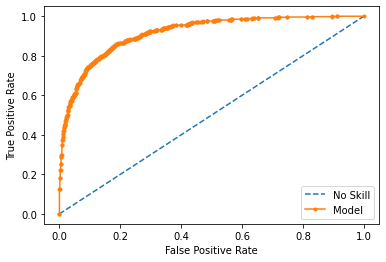

[0.4048187154360439,
 0.8578455484505656,
 0.8348571428571429,
 0.9153389784226518]

In [87]:
score_report(yvalid, predictions1, bin_preds1)

In [159]:
#model2
'Scores for gridsearched scaled TF-IDF SVD Naive Bayes on raw data.'
# loss: -0.355
# train_df = pd.read_csv('./data/train.csv')
# test_df = pd.read_csv('./data/test.csv')
# xtrain, xvalid, ytrain, yvalid = train_test_split(train_df.user_review.values, y, 
#                                                       stratify=y, 
#                                                       random_state=42, 
#                                                       test_size=0.1, shuffle=True)

#!!!

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
# tfv.fit(list(xtrain) + list(xvalid))
# xtrain_tfv =  tfv.transform(xtrain) 
# xvalid_tfv = tfv.transform(xvalid)
#code paste from above
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)


'''nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])'''
###
'''
clf = MultinomialNB(alpha=0.1)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)

mname='Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on {} data.'.format(splits[suffix])
print(mname)
scores = [score_report(yvalid, predictions, bin_preds)]
model_scores.append([mname, scores])

model2 = model
'''

nb_model = MultinomialNB(alpha = 0.1)
pipe_2 = pipeline.Pipeline([('nb', nb_model)])


#

pipe_2.fit(xtrain_tfv, ytrain)

predictions2 = pipe_2.predict_proba(xvalid_tfv)
bin_preds2 = pipe_2.predict(xvalid_tfv)
#bin_preds2=np.argmax(bin_preds2.astype('int64'),axis=1)

Model Log-loss: 0.405 
Model F1 score: 0.868 
Model Accuracy score: 0.846 
Naive ROC AUC=0.500
Model ROC AUC=0.927


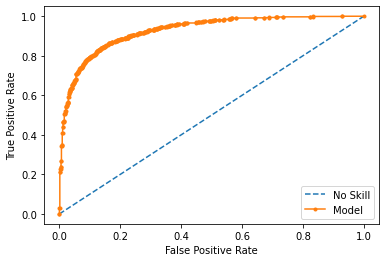

[0.4048187154360439,
 0.8675529295913342,
 0.8462857142857143,
 0.9268962265281903]

In [160]:
predictions2 = pipe_2.predict_proba(xvalid_tfv)
bin_preds2 = pipe_2.predict(xvalid_tfv)
score_report(yvalid, predictions2, bin_preds2)

Model Log-loss: 0.405 
Model F1 score: 0.868 
Model Accuracy score: 0.846 
Naive ROC AUC=0.500
Model ROC AUC=0.927


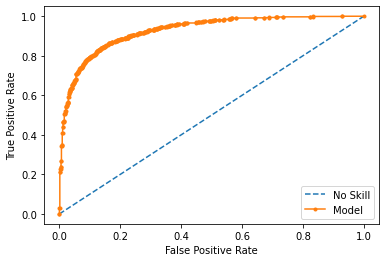

[0.4048187154360439,
 0.8675529295913342,
 0.8462857142857143,
 0.9268962265281903]

In [161]:
predictions2n = nb_model.predict_proba(xvalid_tfv)
bin_preds2n = nb_model.predict(xvalid_tfv)
score_report(yvalid, predictions2n, bin_preds2n)

In [163]:
#The following function returns the words with the highest probability of appearing, given positive or given negative review
#note that popular words like 'game' show up highly in each
def get_salient_words(nb_clf, vect, class_ind):
    """Return salient words for given class
    Parameters
    ----------
    nb_clf : a Naive Bayes classifier (e.g. MultinomialNB, BernoulliNB)
    vect : CountVectorizer
    class_ind : int, 0 or 1
    Returns
    -------
    list
        a sorted list of (word, log prob) sorted by log probability in descending order.
    """
    #adapted from: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

    '''words = vect.get_feature_names()
    zipped = list(zip(words, nb_clf.feature_log_prob_[class_ind]))
    sorted_zip = sorted(zipped, key=lambda t: t[1], reverse=True)'''
    words = tfv.get_feature_names()
    zipped = list(zip(words, nb_clf.feature_log_prob_[class_ind]))
    sorted_zip = sorted(zipped, key=lambda t: t[1], reverse=True)

    return sorted_zip

neg_salient_top_20 = get_salient_words(nb_model, ctv, 0)[:30]
pos_salient_top_20 = get_salient_words(nb_model, ctv, 1)[:30]

In [178]:
tfv.get_feature_names()

['0',
 '0 0',
 '0 00',
 '0 01',
 '0 1',
 '0 10',
 '0 100',
 '0 2',
 '0 2 hours',
 '0 25',
 '0 3',
 '0 4',
 '0 5',
 '0 5 10',
 '0 7',
 '0 8',
 '0 8 hours',
 '0 9',
 '0 99',
 '0 balance',
 '0 chance',
 '0 damage',
 '0 game',
 '0 kills',
 '0 release',
 '0 s',
 '0 skill',
 '0 tanks',
 '0 tier',
 '0 update',
 '00',
 '00 came',
 '00 dota',
 '00 patch',
 '00 update',
 '00 usd',
 '000',
 '000 000',
 '000 astral',
 '000 astral diamonds',
 '000 buy',
 '000 credits',
 '000 game',
 '000 gold',
 '000 hours',
 '000 hours game',
 '000 just',
 '000 players',
 '000 robits',
 '000 rp',
 '000 s',
 '000 silver',
 '000 times',
 '0001',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '07 2016',
 '08',
 '09',
 '1',
 '1 0',
 '1 000',
 '1 000 000',
 '1 000 hours',
 '1 1',
 '1 1 1',
 '1 1 2',
 '1 10',
 '1 10 game',
 '1 10 s',
 '1 100',
 '1 1000',
 '1 12',
 '1 15',
 '1 2',
 '1 2 1',
 '1 2 3',
 '1 2 cup',
 '1 2 days',
 '1 2 games',
 '1 2 hour',
 '1 2 hours',
 '1 2 minutes',
 '1 2 tanks',
 '1 2 times',
 '1 2 wee

In [184]:
#adapted from: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
#get priors
prob_pos = np.exp(nb_model.class_log_prior_[1])
prob_neg = np.exp(nb_model.class_log_prior_[0])
prob_nonneg = prob_pos

df_nbf = pd.DataFrame(index = tfv.get_feature_names())
#df_nbf.index = tfv.get_feature_names()
# Convert log probabilities to probabilities. 
df_nbf['pos'] = np.e**(nb_model.feature_log_prob_[0, :])
df_nbf['neg'] = np.e**(nb_model.feature_log_prob_[1, :])


df_nbf['odds_positive'] = (nb_model.feature_log_prob_[0, :])/(nb_model.feature_log_prob_[1, :])*(prob_nonneg/prob_neg)

df_nbf['odds_negative'] = (nb_model.feature_log_prob_[1, :])/(nb_model.feature_log_prob_[0, :])*(prob_neg/prob_nonneg)


# Here are the top5 most important words of your positive class:
odds_pos_top5 = df_nbf.sort_values('odds_positive',ascending=False)['odds_positive'][:10]
# Here are the top5 most important words of your negative class:
odds_neg_top5 = df_nbf.sort_values('odds_negative',ascending=False)['odds_negative'][:10]


In [185]:
odds_pos_top5

blueprints               1.809545
horror games             1.803511
space combat             1.786129
best arpg                1.775334
diablo ii                1.770553
d3                       1.763487
8 5 10                   1.763107
access reviewone best    1.762845
reviewone best           1.762845
overall great            1.762776
Name: odds_positive, dtype: float64

In [186]:
odds_neg_top5

loot update         1.106872
dont bother         1.104273
epic loot update    1.079466
used love game      1.074708
epic loot           1.073445
freejam             1.059434
game used good      1.059226
wanted like game    1.053076
fj                  1.048414
t waste time        1.042977
Name: odds_negative, dtype: float64

In [167]:
#ctv.get_feature_names()
nb_model.feature_log_prob_

array([[ -8.15522894, -10.98855611, -11.63376371, ..., -13.34537966,
        -13.34537966, -13.34537966],
       [ -8.70181683, -11.3282105 , -11.27474188, ..., -11.82317256,
        -11.82317256, -11.82317256]])

In [164]:
neg_salient_top_20

[('game', -5.550275269804979),
 ('t', -6.050704261921788),
 ('just', -6.215430514956928),
 ('play', -6.266672450748485),
 ('s', -6.280595191390626),
 ('access', -6.387641296919391),
 ('like', -6.395981015630865),
 ('early', -6.421891096032537),
 ('early access', -6.44752168771784),
 ('time', -6.484750831109832),
 ('money', -6.509516245635387),
 ('good', -6.626221605211163),
 ('pay', -6.6396249947511174),
 ('don', -6.665123737839895),
 ('don t', -6.666772866448434),
 ('fun', -6.702351108310305),
 ('really', -6.781623494844648),
 ('want', -6.832063226372979),
 ('new', -6.840181091409143),
 ('playing', -6.87786206856946),
 ('make', -6.8813981150610175),
 ('players', -6.8886979416791645),
 ('games', -6.889925156090435),
 ('bad', -6.890594849871541),
 ('2', -6.906999565610483),
 ('people', -6.9141217477438985),
 ('hours', -6.980015792426699),
 ('1', -6.990891755917282),
 ('played', -7.003709026726491),
 ('buy', -7.017326135060052)]

In [157]:
neg_salient_top_20#old

[('the', -4.3521078080021445),
 ('to', -4.597020389947719),
 ('and', -4.805426322811935),
 ('game', -4.8319356764883254),
 ('you', -4.858164019339275),
 ('it', -4.927269102686113),
 ('of', -5.127065513065722),
 ('this', -5.12747179042137),
 ('is', -5.138258747527058),
 ('that', -5.370886268829528),
 ('in', -5.39367590378615),
 ('for', -5.4038082590938),
 ('but', -5.537336986617081),
 ('have', -5.629965358890185),
 ('not', -5.635247792865848),
 ('with', -5.65015661517114),
 ('they', -5.679526428826743),
 ('are', -5.745740964841928),
 ('on', -5.748903320953501),
 ('was', -5.756892863403492),
 ('just', -5.77742460261274),
 ('get', -5.824112852141534),
 ('play', -5.834503708235934),
 ('if', -5.841180048872557),
 ('be', -5.859588531083589),
 ('so', -5.92823210978997),
 ('can', -5.947081663276889),
 ('your', -5.949291185948507),
 ('as', -5.953229933499037),
 ('or', -5.974283146947106)]

In [158]:
pos_salient_top_20#old

[('the', -4.379971921841315),
 ('and', -4.638486694218655),
 ('to', -4.654876780011872),
 ('you', -4.77742742085859),
 ('game', -4.7819390739805865),
 ('it', -4.810422270033956),
 ('is', -4.927905496159424),
 ('of', -4.991434741188952),
 ('this', -5.136979044396443),
 ('in', -5.346233610616878),
 ('for', -5.360699805667825),
 ('that', -5.375865513513552),
 ('but', -5.4855491432939685),
 ('with', -5.547559113000726),
 ('are', -5.597083519503826),
 ('can', -5.617408124344523),
 ('have', -5.654503044073098),
 ('like', -5.6889088244760835),
 ('play', -5.7019954840121025),
 ('on', -5.718778589235459),
 ('if', -5.780267687430884),
 ('as', -5.797919627416449),
 ('not', -5.842585332156175),
 ('be', -5.844673861706049),
 ('fun', -5.851932217836897),
 ('so', -5.859820399570089),
 ('good', -5.886412426531073),
 ('early', -5.906352396514789),
 ('access', -5.9222888122178885),
 ('get', -5.9304542830860125)]

In [165]:
pos_salient_top_20

[('game', -5.517831548204499),
 ('s', -6.060252638858862),
 ('like', -6.156262959147678),
 ('play', -6.168061621800087),
 ('early', -6.288267813249039),
 ('fun', -6.290202032033184),
 ('access', -6.300314315189214),
 ('early access', -6.314334300548475),
 ('good', -6.331873876776993),
 ('t', -6.3339194466942095),
 ('free', -6.4095200364955955),
 ('great', -6.462552500168547),
 ('just', -6.4958106519420475),
 ('really', -6.516800345121803),
 ('games', -6.547088088758073),
 ('time', -6.5653518982933905),
 ('10', -6.587549487618031),
 ('playing', -6.677115001645643),
 ('best', -6.7757567190399355),
 ('played', -6.790844708701282),
 ('people', -6.844201667800266),
 ('love', -6.852142691429861),
 ('new', -6.8901074483395295),
 ('better', -6.897194297191573),
 ('lot', -6.903069086301819),
 ('don', -6.937171754686084),
 ('don t', -6.938143601591091),
 ('ve', -6.96024213871019),
 ('recommend', -6.977573175852221),
 ('hours', -6.995440613638029)]

In [154]:
# count_vect = ctv
# neg_class_prob_sorted = nb_model.feature_log_prob_[0, :].argsort()[::-1]
# pos_class_prob_sorted = nb_model.feature_log_prob_[1, :].argsort()[::-1]

# print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
# print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

MemoryError: Unable to allocate 52.4 GiB for an array with shape (1758610,) and data type <U8000

In [98]:
bin_preds3

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Epoch 1/100
31/31 [==============================] - 396s 13s/step - loss: 0.6905 - val_loss: 0.5935
Epoch 2/100
31/31 [==============================] - 439s 14s/step - loss: 0.5900 - val_loss: 0.5077
Epoch 3/100
31/31 [==============================] - 458s 15s/step - loss: 0.5537 - val_loss: 0.4914
Epoch 4/100
31/31 [==============================] - 468s 15s/step - loss: 0.5087 - val_loss: 0.4633
Epoch 5/100
31/31 [==============================] - 473s 15s/step - loss: 0.4784 - val_loss: 0.4533
Epoch 6/100
31/31 [==============================] - 488s 16s/step - loss: 0.4627 - val_loss: 0.4722
Epoch 7/100
31/31 [==============================] - 497s 16s/step - loss: 0.4513 - val_loss: 0.4218
Epoch 8/100
31/31 [==============================] - 499s 16s/step - loss: 0.4489 - val_loss: 0.4365
Epoch 9/100
31/31 [==============================] - 511s 16s/step - loss: 0.4257 - val_loss: 0.4035
Epoch 10/100
31/31 [==============================] - 509s 16s/step - loss: 0.4114 - val_lo

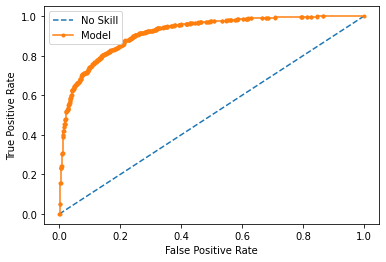

"clf_lr = pipeline.Pipeline([('svd', svd),\n                         ('scl', scl),\n                         ('lr', lr_model)])\n\n#Set up the parameter grid\nparam_grid = {'svd__n_components' : [120, 180],\n              'lr__C': [0.1, 1.0, 10], \n              'lr__penalty': ['l1', 'l2']}\n       \n                         \nmodel = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,\n                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)\nmodel.fit(xtrain_tfv, ytrain) \n"

In [92]:
#model3
# 2-layer Bidirectional GRU with glove embeddings and two 1024 dense layers
# 0.3717 -------------------------------------------------------------------------- model 3
#possibly add _pad step to pipeline?
gru_model = Sequential()
gru_model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
gru_model.add(SpatialDropout1D(0.3))
gru_model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
#model.add(RepeatVector(2)) # Repeat Vector
gru_model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

gru_model.add(Dense(1024, activation='relu'))
gru_model.add(Dropout(0.8))

gru_model.add(Dense(1024, activation='relu'))
gru_model.add(Dropout(0.8))

gru_model.add(Dense(2))
gru_model.add(Activation('softmax'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam')
pipe_3 = pipeline.Pipeline([('gru', gru_model)])

#param grid available for gridsearch if wanted
# param_grid = {'gru_model__batch_size' : [512],
#               'gru_model__epochs': [25], 
#               'gru_model__verbose': [1],
#              'gru_model__validation_data': [(xvalid_pad, yvalid_enc)],
#              'gru_model__callbacks': [earlystop]}

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
pipe_3.fit(xtrain_pad, y=ytrain_enc, gru__batch_size=512, gru__epochs=100, 
          gru__verbose=1, gru__validation_data=(xvalid_pad, yvalid_enc), gru__callbacks=[earlystop])

#
predictions3 = pipe_3.predict_proba(xvalid_pad)
bin_preds3 = pipe_3.predict(xvalid_pad).round()
bin_preds3=np.argmax(bin_preds3.astype('int64'),axis=1)
score_report(yvalid, predictions3, bin_preds3)
'''clf_lr = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

#Set up the parameter grid
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}
       
                         
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)
model.fit(xtrain_tfv, ytrain) 
'''

Model Log-loss: 0.405 
Model F1 score: 0.853 
Model Accuracy score: 0.831 
Naive ROC AUC=0.500
Model ROC AUC=0.916


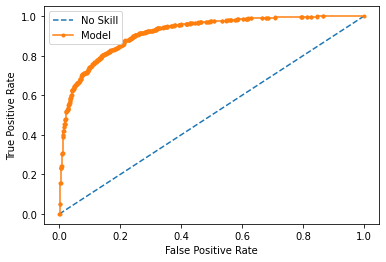

[0.4048187154360439,
 0.8531746031746031,
 0.8308571428571428,
 0.9156033838567494]

In [124]:
bin_preds=np.argmax(bin_preds.astype('int64'),axis=1)
bin_preds3=np.argmax(bin_preds3.astype('int64'),axis=1)
score_report(yvalid, predictions3, bin_preds3)


In [122]:
bin_preds3=np.argmax(bin_preds3.astype('int64'),axis=1)
temp2
temp2=np.argmax(temp,axis=1)
temp2
#yvalid
accuracy_score(yvalid, temp2)

0.8308571428571428

In [ ]:
##sample from prior project
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.compose import make_column_transformer, ColumnTransformer
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import FeatureUnion
# from sklearn.pipeline import make_pipeline
# from sklearn.pipeline import Pipeline

# '''
# Best xgb params: 
# learning_rate: 0.2
# max_depth: 6
# min_child_weight: 1
# n_estimators: 200
# subsample: 0.7'''

# pipe_fin = Pipeline(steps=[
#     ('dropFeats', dropFeats()),
#     ('customFeats', customFeats()),
#     ('scaler', StandardScaler()), 
#     ('XGBclf', XGBClassifier(learning_rate=lr,max_depth=md,min_child_weight=mcw,n_estimators=ne,subsample=ss, random_state=random_state_val))
#     #('XGBclf', XGBClassifier(learning_rate=0.2,max_depth=6,min_child_weight=1,n_estimators=200,subsample=0.7, random_state=random_state_val))

# #     ('RFclf', RandomForestClassifier( criterion='gini', 
# #                                     max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=30)) 
#     #random_state=random_state_val,
#     #('GBclf', GradientBoostingClassifier(learning_rate=0.3, max_depth=7, min_samples_split=3, n_estimators=50, random_state=random_state_val))
#     #('GBclf', GradientBoostingClassifier(learning_rate=1, max_depth=10, min_samples_split=5, n_estimators=50, random_state=random_state_val))
#     ])

# #    

# pipe_fin.fit(ftx, fty)
# # print(pipe_fin.score(ftx, fty))
# # print(pipe_fin.score(ftx_test, fty_test))
# #print(pipe_fin.get_params())
# train_preds = pipe_fin.predict(ftx)
# test_preds = pipe_fin.predict(ftx_test)
# print('Recall score training:', recall( fty, train_preds))
# print('Recall score test:', recall( fty_test, test_preds))

# print('Accuracy score training:', accuracy( fty, train_preds))
# print('Accuracy score test:', accuracy( fty_test, test_preds))


In [ ]:
#pickling
# with open('clf_model_1.pkl', 'wb') as f:
#     pickle.dump(pipe_fin,f)

In [ ]:
# with open('clf_model_1.pkl', 'rb') as f:
#     unpickled_pipe = pickle.load(f)
    
# print('Unpickled Accuracy:', unpickled_pipe.score(ftx_test, fty_test))

# if unpickled_pipe.score(ftx_test, fty_test) == pipe_fin.score(ftx_test, fty_test):
#     print('Pickled and unpickled models produce same Recall scores!')